In [4]:
import os
# garbage collection
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Voting Model
This class prepares a voting model from the individual fold level contributions

In [50]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0) # หา mean ในแต่ละ column (คำนวณใน row) 
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

# Data preprocessing

In [51]:
class Pipeline:
    @staticmethod
    # set data types for columns based on their names
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            # P : Transform DPD (Days past due)
            # A : Transform amount
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            # M : Masking categories
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            # D : Transform date
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    # subtracts the date column, converts it to total days, and casts it to Float32.
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    # filters out columns with more than 95% missing values, drops string columns with only one unique value
    # drops string columns with only one unique value or more than 200 unique values
    # drops columns that are not "target", "case_id", or "WEEK_NUM".
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df         [col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [52]:
class Aggregator:
    @staticmethod
    # return list of
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [53]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

In [54]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [55]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [56]:
ROOT            = Path("home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [57]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [74]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    # if depth in [1, 2]:
    #     df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

x = read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1)
y = Aggregator.get_exprs(x)
z = Aggregator.num_expr(x)


In [75]:
y
z

[<Expr ['col("max_actualdpd_943P").max(…'] at 0x150A1D400>,
 <Expr ['col("max_annuity_853A").max().…'] at 0x169D34850>,
 <Expr ['col("max_credacc_actualbalance…'] at 0x15083EAF0>,
 <Expr ['col("max_credacc_credlmt_575A"…'] at 0x15083EEE0>,
 <Expr ['col("max_credacc_maxhisbal_375…'] at 0x15083ED30>,
 <Expr ['col("max_credacc_minhisbal_90A…'] at 0x15083ED60>,
 <Expr ['col("max_credamount_590A").max…'] at 0x15083EC10>,
 <Expr ['col("max_currdebt_94A").max().…'] at 0x15083ED00>,
 <Expr ['col("max_downpmt_134A").max().…'] at 0x150A18400>,
 <Expr ['col("max_mainoccupationinc_437…'] at 0x150A183D0>,
 <Expr ['col("max_maxdpdtolerance_577P"…'] at 0x150A181C0>,
 <Expr ['col("max_outstandingdebt_522A"…'] at 0x150A184F0>,
 <Expr ['col("max_revolvingaccount_394A…'] at 0x150A184C0>]

In [77]:
j = Aggregator.count_expr(x)
j

[<Expr ['col("max_num_group1").max().al…'] at 0x150A18FD0>]

In [58]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 472)


In [59]:
data_store["df_base"]

case_id,date_decision,MONTH,WEEK_NUM,target
i32,date,i64,i32,i64
0,2019-01-03,201901,0,0
1,2019-01-03,201901,0,0
2,2019-01-04,201901,0,0
3,2019-01-03,201901,0,0
4,2019-01-04,201901,0,1
…,…,…,…,…
2703450,2020-10-05,202010,91,0
2703451,2020-10-05,202010,91,0
2703452,2020-10-05,202010,91,0


In [60]:
data_store["depth_0"]

[shape: (1_500_476, 53)
 ┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ case_id ┆ assignment ┆ assignmen ┆ assignmen ┆ … ┆ riskasses ┆ riskasses ┆ secondqua ┆ thirdquar │
 │ ---     ┆ date_238D  ┆ tdate_452 ┆ tdate_495 ┆   ┆ ment_302T ┆ ment_940T ┆ rter_766L ┆ ter_1082L │
 │ i32     ┆ ---        ┆ 7235D     ┆ 5616D     ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │         ┆ date       ┆ ---       ┆ ---       ┆   ┆ str       ┆ f64       ┆ f64       ┆ f64       │
 │         ┆            ┆ date      ┆ date      ┆   ┆           ┆           ┆           ┆           │
 ╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 357     ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
 │ 381     ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
 │ 388     ┆ null       ┆ null      ┆ null      ┆ … ┆ null

In [61]:
data_store["depth_1"]

[shape: (1_221_522, 41)
 ┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ case_id ┆ max_actual ┆ max_annui ┆ max_creda ┆ … ┆ max_pmtnu ┆ max_statu ┆ max_tenor ┆ max_num_g │
 │ ---     ┆ dpd_943P   ┆ ty_853A   ┆ cc_actual ┆   ┆ m_8L      ┆ s_219L    ┆ _203L     ┆ roup1     │
 │ i32     ┆ ---        ┆ ---       ┆ balance_3 ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │         ┆ f64        ┆ f64       ┆ 14A       ┆   ┆ f64       ┆ str       ┆ f64       ┆ i32       │
 │         ┆            ┆           ┆ ---       ┆   ┆           ┆           ┆           ┆           │
 │         ┆            ┆           ┆ f64       ┆   ┆           ┆           ┆           ┆           │
 ╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 666174  ┆ 0.0        ┆ null      ┆ null      ┆ … ┆ null      ┆ T         ┆ null      ┆ 0         │
 │ 1592113 ┆ 0.0        ┆ 3591.6    ┆ null      ┆ … ┆ 6.0 

In [35]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [36]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 471)


In [37]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


In [38]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [39]:
del data_store

gc.collect()

4078

In [40]:
df_test

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,...,max_subjectroles_name_541M,max_subjectroles_name_838M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_pmts_month_158T,max_pmts_month_706T,max_pmts_year_1139T,max_pmts_year_507T,max_num_group1_13,max_num_group2_13
0,57543,100,5,5,NaN,NaN,NaN,151364.00,-14804.0,2.0,...,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2021.0,2018.0,9.0,0.0
1,57549,100,1,1,NaN,NaN,NaN,1563077.92,-22723.0,6.0,...,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2022.0,2019.0,9.0,0.0
2,57551,100,11,5,NaN,NaN,NaN,2926195.30,-14090.0,1.0,...,ab3c25cf,ab3c25cf,0.0,75200.0,2.0,2.0,2020.0,2017.0,12.0,0.0
3,57552,100,11,5,NaN,NaN,NaN,747031.73,-23768.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57569,100,12,1,NaN,NaN,NaN,NaN,-26408.0,4.0,...,ab3c25cf,a55475b1,NaN,0.0,NaN,10.0,NaN,2019.0,1.0,8.0
5,57630,100,3,2,NaN,NaN,NaN,499975.00,-19767.0,1.0,...,ab3c25cf,ab3c25cf,0.0,0.0,10.0,10.0,2021.0,2015.0,1.0,8.0
6,57631,100,6,6,NaN,NaN,NaN,480334.49,-12999.0,0.0,...,ab3c25cf,ab3c25cf,0.0,0.0,10.0,10.0,2019.0,2018.0,1.0,8.0
7,57632,100,2,6,NaN,NaN,NaN,17677.00,-23107.0,1.0,...,a55475b1,ab3c25cf,0.0,NaN,11.0,NaN,2019.0,NaN,0.0,9.0
8,57633,100,1,2,NaN,NaN,NaN,6373008.21,-10496.0,3.0,...,ab3c25cf,ab3c25cf,7230000.0,0.0,3.0,3.0,2021.0,2021.0,8.0,1.0
9,57634,100,1,3,NaN,NaN,NaN,15263.65,-16281.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


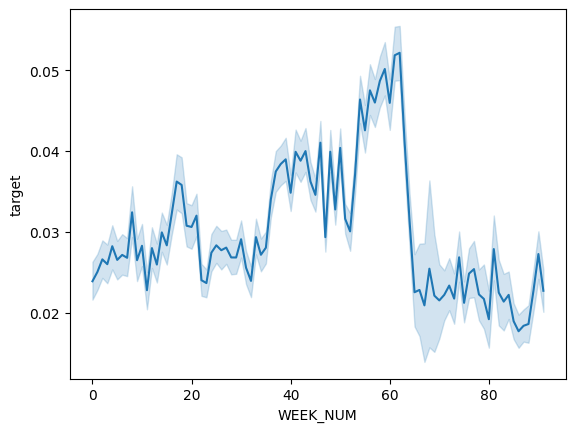

In [42]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()


In [43]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]

In [45]:
X

,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,...,max_subjectroles_name_541M,max_subjectroles_name_838M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_pmts_month_158T,max_pmts_month_706T,max_pmts_year_1139T,max_pmts_year_507T,max_num_group1_13,max_num_group2_13
0,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,10,1,NaN,NaN,NaN,52863.59,-22193.0,0.0,0.0,0.0,...,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2021.0,10.0,35.0
1526655,10,1,NaN,NaN,NaN,324608.52,-25541.0,0.0,0.0,0.0,...,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2021.0,3.0,23.0
1526656,10,1,NaN,NaN,NaN,102738.76,-15771.0,2.0,2.0,0.0,...,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2020.0,2.0,35.0
1526657,10,1,NaN,NaN,NaN,212683.29,-25814.0,2.0,2.0,1.0,...,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2020.0,12.0,35.0


In [47]:
y.value_counts()

target
0    1478665
1      47994
Name: count, dtype: int64

In [20]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.836989
[200]	valid_0's auc: 0.84626
[300]	valid_0's auc: 0.849643
[400]	valid_0's auc: 0.850922
[500]	valid_0's auc: 0.851649
[600]	valid_0's auc: 0.852131
[700]	valid_0's auc: 0.852327
[800]	valid_0's auc: 0.852499
[900]	valid_0's auc: 0.852843
[1000]	valid_0's auc: 0.853043
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.853052
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.838819
[200]	valid_0's auc: 0.847793
[300]	valid_0's auc: 0.850553
[400]	valid_0's auc: 0.851739
[500]	valid_0's auc: 0.85239
[600]	valid_0's auc: 0.852906
[700]	valid_0's auc: 0.85324
[800]	valid_0's auc: 0.8533
[900]	valid_0's auc: 0.853342
[1000]	valid_0's auc: 0.853496
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.853515
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.843069
[200]	valid_0's auc: 0.852462
[

In [ ]:
x_train

In [21]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)
x

In [22]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [23]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.008026
57549,0.061721
57551,0.004157
57552,0.017645
57569,0.188840
